# Amazon Product Review Sentiments
This project focuses on analyzing sentiments expressed in Amazon product reviews. Using natural language processing techniques, the aim is to classify reviews as positive, neutral, or negative based on the text content. By leveraging machine learning algorithms, insights can be derived to understand customer opinions and sentiments towards various Amazon products, aiding businesses in gauging consumer satisfaction and improving product offerings.

## Part 1: Data Explorations

In [185]:
# import libraries
import pandas as pd
import spacy
import datetime as st
import matplotlib.pyplot as plt
import seaborn as sns
from spacytextblob.spacytextblob import SpacyTextBlob
from textblob import TextBlob

# Adjust pandas display options
pd.set_option('display.max_colwidth', None)

In [52]:
# import the spacy's small model to perform the NLP processing 
nlp = spacy.load('en_core_web_sm')

In [92]:
# load the review data
df = pd.read_csv('amazon_product_reviews.csv', low_memory=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    34660 non-null  object 
 1   name                  27900 non-null  object 
 2   asins                 34658 non-null  object 
 3   brand                 34660 non-null  object 
 4   categories            34660 non-null  object 
 5   keys                  34660 non-null  object 
 6   manufacturer          34660 non-null  object 
 7   reviews.date          34621 non-null  object 
 8   reviews.dateAdded     24039 non-null  object 
 9   reviews.dateSeen      34660 non-null  object 
 10  reviews.didPurchase   1 non-null      object 
 11  reviews.doRecommend   34066 non-null  object 
 12  reviews.id            1 non-null      float64
 13  reviews.numHelpful    34131 non-null  float64
 14  reviews.rating        34627 non-null  float64
 15  reviews.sourceURLs 

In [171]:
# display the number of reviews per product
product_reviews_counts = df.groupby('name').size().sort_values(ascending=False)
product_counts

name
Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta                                                                                                                                              10966
Echo (White),,,\r\nEcho (White),,,                                                                                                                                                                                   3309
Amazon Kindle Paperwhite - eBook reader - 4 GB - 6 monochrome Paperwhite - touchscreen - Wi-Fi - black,,,                                                                                                            3176
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta                                                                                                                              2814
Amazon Fire Tv,,,\r\nAmazon Fire Tv,,,                                                                                     

In [71]:
# Identify any missing data
missing_data_rows = []
total_rows = len(df)

for num in df.columns:
    missing_values_count = df[num].isnull().sum()
    percentage_missing_per_column = round((missing_values_count / total_rows) * 100)
    missing_data_rows.append({'Feature': num,'Missing Values Count': missing_values_count,'Percentage Missing': f"{percentage_missing_per_column}%"})

# convert the list of dictionaries into a dataFrame
missing_output_df = pd.DataFrame(missing_data_rows)
missing_output_df

,Feature,Missing Values Count,Percentage Missing
0,id,0,0%
1,name,6760,20%
2,asins,2,0%
3,brand,0,0%
4,categories,0,0%
5,keys,0,0%
6,manufacturer,0,0%
7,reviews.date,39,0%
8,reviews.dateAdded,10621,31%
9,reviews.dateSeen,0,0%


It appears that only 1 record is missing the review text which I'm going to drop it.

In [56]:
# select the reviews from the 'reviews.text' column and remove missing values
text = df[['reviews.text']].dropna()
text

,reviews.text
0,This product so far has not disappointed. My c...
1,great for beginner or experienced person. Boug...
2,Inexpensive tablet for him to use and learn on...
3,I've had my Fire HD 8 two weeks now and I love...
4,I bought this for my grand daughter when she c...
...,...
34655,This is not appreciably faster than any other ...
34656,Amazon should include this charger with the Ki...
34657,Love my Kindle Fire but I am really disappoint...
34658,I was surprised to find it did not come with a...


In [172]:
# display a sample review text from the dataset
sample_review = df['reviews.text'][3800]
sample_review

'For the money the best tablet you can buy. I bought a bunch of these for my nieces to play with. I love my kindle and for the money it allows them to do a wide variety of activities.'

In [173]:
# get the time period that the reviews were collected in
df['reviews.dateAdded'] = pd.to_datetime(df['reviews.dateAdded']).dt.date

# Filter out NaT values
filtered_dates = df['reviews.date'].dropna()

# Get the minimum and maximum dates
min_date = min(filtered_dates)
max_date = max(filtered_dates)

# Print the result
print(f"\nThe reviews are collected between {min_date} and {max_date}\n")


The reviews are collected between 2010-07-09T00:00:00Z and 2018-04-18T00:00:00.000Z



## Part 2: Data Preprocessing
At this stage, the data will be converted to string format, lowercased, lemmatized, stripped of whitespace, tokenised (converted to vector) and have stopwords and punctuation removed.

In [156]:
# Function to clean and preprocess text using spaCy
def preprocess_text(text):
    """
    Preprocesses the input text by performing the following steps:
    1. Converts the input text to a string (to ensure compatibility with spaCy).
    2. Processes the text with spaCy to create a doc object.
    3. Extracts tokens from the doc object, performing the following for each token:
        - Converts the token to its lemma (base form).
        - Converts the token to lowercase.
        - Strips any leading or trailing whitespace from the token.
        - Excludes tokens that are stopwords (common words with little semantic value).
        - Excludes tokens that are punctuation.
    4. Joins the processed tokens into a single string with space as a delimiter.
    
    Args:
    text (str): The input text to be processed.

    Returns:
    str: A string of processed tokens ready for further analysis.
    """
    doc = nlp(str(text)) 
    tokens = [token.lemma_.lower().strip() for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(tokens)

# Apply the preprocessing function to each review
df['cleaned_review'] = df['reviews.text'].apply(preprocess_text)
df['cleaned_review']

0        product far disappoint child love use like abi...
1          great beginner experienced person buy gift love
2        inexpensive tablet use learn step nabi thrille...
3        fire hd 8 week love tablet great value prime m...
4        buy grand daughter come visit set user enter a...
                               ...                        
34655    appreciably fast 1.8 high amp charger kindle k...
34656    amazon include charger kindle fact charge extr...
34657    love kindle fire disappointed kindle power fas...
34658    surprised find come type charge cord purchase ...
34659    spite fact good thing amazon anthe get love fi...
Name: cleaned_review, Length: 34660, dtype: object

## Part 3: Sentiment Model

In [157]:
# Function to predict sentiment using TextBlob
def predict_sentiment(text):
    """
    Predicts the sentiment of the input text using the TextBlob library.
    The function performs the following steps:
    1. Converts the input text to a string (to ensure compatibility with TextBlob).
    2. Creates a TextBlob object from the input text.
    3. Calculates the polarity of the text using TextBlob's sentiment analysis:
        - Polarity is a float within the range [-1.0, 1.0].
        - Positive polarity indicates positive sentiment.
        - Negative polarity indicates negative sentiment.
        - Polarity of zero indicates neutral sentiment.
    4. Returns the sentiment as a string: 'Positive', 'Negative', or 'Neutral', based on the polarity score.

    Args:
    text (str): The input text to be analyzed for sentiment.

    Returns:
    str: The predicted sentiment of the text ('Positive', 'Negative', or 'Neutral').
    """
    blob = TextBlob(str(text))
    polarity = blob.sentiment.polarity
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Add a sentiment column to the dataframe
df['sentiment'] = df['cleaned_review'].apply(predict_sentiment)

In [44]:
# check if the function was able to detect all types of sentiment in the text
df['sentiment'].unique()

array(['Positive', 'Neutral', 'Negative'], dtype=object)

## Part 4: Assess Sentiments

In [197]:
# Test the sentiment analysis function on a few random sample product reviews
sample_reviews = df['cleaned_review'].sample(15).tolist()
sample_predictions = [predict_sentiment(review) for review in sample_reviews]

# Iterate over pairs of sample reviews and their predicted sentiments
for review, sentiment in zip(sample_reviews, sample_predictions):
    # Print each review along with its predicted sentiment in a formatted manner
    print(f"Review: {review}\nSentiment: {sentiment}\n")

Review: integration home automation transparent hope device offer way skill connect system run amazon google apple microsoft amazon research good time purchase make simple deliver promise
Sentiment: Positive

Review: love time go black unplug hook order work multiple time reg fire stick anther tv
Sentiment: Positive

Review: work great sound clear loud recommend
Sentiment: Positive

Review: great job voice recognition work different service capability love alexa
Sentiment: Positive

Review: far good medium box market easy setup extremely easy use kodi user far good box a+++
Sentiment: Positive

Review: pick purchase echo want battery power work echo use device music great able hear pandora amazon music library speaker use phone laptop etc grab tap house outside deck wireless reach
Sentiment: Positive

Review: great product $ exactly need
Sentiment: Positive

Review: buy small echo trade large superior sound happy
Sentiment: Positive

Review: perform way say more!awesome buy
Sentiment: 

After reviewing the sample results above, it's evident that the sentiments are accurately identified based on tokens like 'good,' 'glad,' and 'love,' among others. 

In [198]:
# get the reviews columns along with the achieved sentiment of the last 5 rows  where sentiments are tagged as negative
df[df['sentiment'] == 'Negative'][['reviews.text', 'cleaned_review', 'sentiment']].tail()

,reviews.text,cleaned_review,sentiment
34564,"Amazon Fire TV is worth the cost for me , I watch a lot of shows.The game controller and games, not so much. They remind me of the old style joy stick games...sorry I bought that part., its hard to use.",amazon fire tv worth cost watch lot show game controller game remind old style joy stick game sorry buy hard use,Negative
34572,"I like how it runs Android, so I can sideload any app for Android on the Amazon fire TV. I just wish it supports NTFS file system and have a volume control and power for the actual TV (like a universal remote)",like run android sideload app android amazon fire tv wish support ntfs file system volume control power actual tv like universal remote,Negative
34602,"This Amazon Fire TV is my second unit in my home. I haven't paid for cable since I bought my first unit a couple years ago. If you are an Amazon Prime member, you should seriously already own one.",amazon fire tv second unit home pay cable buy unit couple year ago amazon prime member seriously,Negative
34614,"We had two AppleTVs - one in the master bedroom and one in the living room. We could not watch both simultaneously because the signal permeated the shared wall and changed the channel of the other TV. We got the AmazonTV to remedy this. While it did rectify this problem, we find we prefer the ease and simplicity of the AppleTV over the AmazonTV. The Amazon is cumbersome and difficult to navigate.",appletvs master bedroom living room watch simultaneously signal permeate share wall change channel tv get amazontv remedy rectify problem find prefer ease simplicity appletv amazontv amazon cumbersome difficult navigate,Negative
34654,"This is exactly like any other usb power charger, making it unnecessary. A basic charger used for an ipod works to charge the kindle fire within 3-4 hours.",exactly like usb power charger make unnecessary basic charger ipod work charge kindle fire 3 4 hour,Negative


Among the example reviews above, the 3rd one seems to be incorrectly labeled as Negative as the reviewer strongly recommends this product to the reader.

In [199]:
# Function to find the similarity between 2 reviews
def calculate_similarity(review1, review2):
    """
    Calculates the similarity between two reviews using spaCy's similarity score.

    Args:
    review1 (str): The first review.
    review2 (str): The second review.

    Returns:
    float: The similarity score between the two reviews (a value between 0 and 1).
    """
    # Process the reviews using spaCy
    doc1 = nlp(review1)
    doc2 = nlp(review2)
    
    # Calculate the similarity between the two documents
    similarity_score = doc1.similarity(doc2)
    
    return similarity_score

# Example usage:
review1 = df['cleaned_review'][200]
review2 = df['cleaned_review'][8900]
similarity = calculate_similarity(review1, review2)
print(f"Review 1: {review1}")
print(f"Review 2: {review2}")
print("Similarity:", similarity)

Review 1: buy gift 86 yr old mom stalk kid grandkid fb master few.minutes minimal instruction watch post
Review 2: tablet okay screen small wifi work wifi turn manually reset camera nice resolution sharp need sense version camera big screen size
Similarity: 0.8404784283601816


/var/folders/jf/9cfc0stn05v519631ltpqjmm0000gn/T/ipykernel_52408/1750286037.py:17: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  similarity_score = doc1.similarity(doc2)


The similarity is calculated based on cosine similarity on the word vectors. However, I'm uncertain how the above reviews received a high similarity score, as conceptually they don't appear to be very similar.

Dataset Summary:
- Total reviews: 34660

Sample Original Review:
This product so far has not disappointed. My children love to use it and I like the ability to monitor control what content they see with ease.

Sample Cleaned Review:
product far disappoint child love use like ability monitor control content ease

Processing Steps:
- Loaded spaCy model `en_core_web_sm`.
- Cleaned text using spaCy attributes: is_stop, lower, strip.
- Performed sentiment analysis using TextBlob's polarity.
- Extracted 'review.text' column and removed missing values using dropna().
- Defined a function to predict sentiment based on TextBlob's sentiment analysis.
- Implemented similarity search using spaCy's similarity feature.



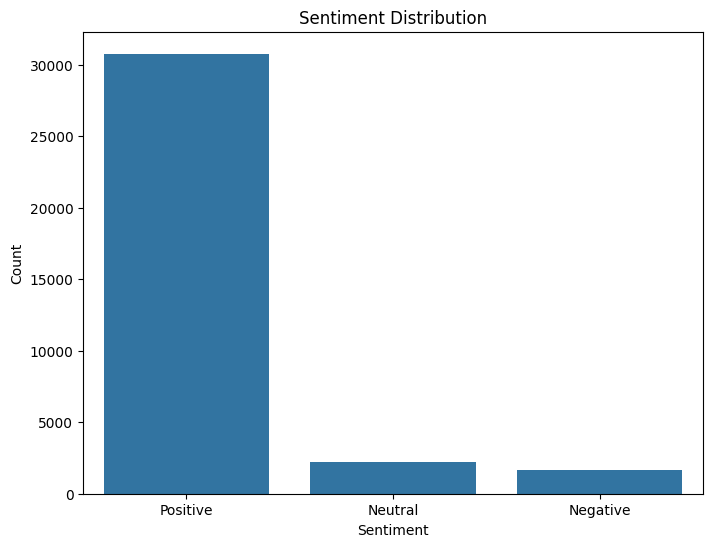


Insights:
- The model uses TextBlob for basic sentiment analysis.
- The similarity feature helps find reviews that are similar in context.
- Further improvements could include using more sophisticated models for better accuracy.


In [200]:
# Summary Report
def summary_report(df):
    total_reviews = df.shape[0]
    sample_review = df['reviews.text'].iloc[0]
    cleaned_review = preprocess_text(sample_review)

    print(f"Dataset Summary:\n- Total reviews: {total_reviews}\n")
    print(f"Sample Original Review:\n{sample_review}\n")
    print(f"Sample Cleaned Review:\n{cleaned_review}\n")
    print("Processing Steps:")
    print("- Loaded spaCy model `en_core_web_sm`.")
    print("- Cleaned text using spaCy attributes: is_stop, lower, strip.")
    print("- Performed sentiment analysis using TextBlob's polarity.")
    print("- Extracted 'review.text' column and removed missing values using dropna().")
    print("- Defined a function to predict sentiment based on TextBlob's sentiment analysis.")
    print("- Implemented similarity search using spaCy's similarity feature.\n")

    # Create a bar plot
    sentiment_counts = df['sentiment'].value_counts()
    
    # Convert Series to DataFrame
    sentiment_counts_df = sentiment_counts.reset_index()
    sentiment_counts_df.columns = ['Sentiment', 'Count']
    
    # Create a bar plot
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Sentiment', y='Count', data=sentiment_counts_df)
    plt.title('Sentiment Distribution')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.show()
    print("\nInsights:")
    print("- The model uses TextBlob for basic sentiment analysis.")
    print("- The similarity feature helps find reviews that are similar in context.")
    print("- Further improvements could include using more sophisticated models for better accuracy.")

summary_report(df)

89% of reviews are labelled as **Positive** by the sentiment model.